In [1]:
import pickle
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import xgboost as xgb
import matplotlib.pyplot as plt 
import seaborn as sns  
import time
from scipy import stats
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import NearMiss  
from sklearn.pipeline import make_pipeline 
from sklearn.svm import LinearSVC, SVC 
from sklearn.model_selection import GridSearchCV
from scipy.stats import loguniform, uniform
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis, pearsonr

In [2]:
pd.pandas.set_option('display.max_columns', None)
data = pd.read_csv("../dataset/LPD_30k.csv", encoding = "unicode_escape")
data.head(10)

,Age,Gender,T_Bil,D_Bil,Alkphos,Sgpt,Sgot,Total_Protiens,Alb,A/G,Result
0,65.0,Female,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1
1,62.0,Male,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1
2,62.0,Male,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1
3,58.0,Male,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,1
4,72.0,Male,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,1
5,46.0,Male,1.8,0.7,208.0,19.0,14.0,7.6,4.4,1.30,1
6,26.0,Female,0.9,0.2,154.0,NaN,12.0,7.0,3.5,1.00,1
7,29.0,Female,0.9,0.3,202.0,14.0,11.0,6.7,3.6,1.10,1
8,17.0,Male,0.9,0.3,202.0,22.0,19.0,7.4,4.1,1.20,2
9,55.0,Male,0.7,0.2,290.0,53.0,58.0,6.8,3.4,1.00,1


In [3]:
duplicates = data[data.duplicated()]
data.drop_duplicates(inplace=True)

In [4]:
# Removing all the null values 
data = data.dropna()
data.shape

(16389, 11)

In [5]:
data["Result"] = data["Result"] - 1

In [6]:
data.shape

(16389, 11)

In [7]:
# Label encoding 
le = LabelEncoder()
gender_encoded = le.fit_transform(data["Gender"])
data["Gender_encoded"] = gender_encoded
data = data.drop(["Gender"], axis = 1)
data.head(10)

,Age,T_Bil,D_Bil,Alkphos,Sgpt,Sgot,Total_Protiens,Alb,A/G,Result,Gender_encoded
0,65.0,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,0,0
1,62.0,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,0,1
2,62.0,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,0,1
3,58.0,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,0,1
4,72.0,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,0,1
5,46.0,1.8,0.7,208.0,19.0,14.0,7.6,4.4,1.30,0,1
7,29.0,0.9,0.3,202.0,14.0,11.0,6.7,3.6,1.10,0,0
8,17.0,0.9,0.3,202.0,22.0,19.0,7.4,4.1,1.20,1,1
9,55.0,0.7,0.2,290.0,53.0,58.0,6.8,3.4,1.00,0,1
10,57.0,0.6,0.1,210.0,51.0,59.0,5.9,2.7,0.80,0,1


In [8]:
# Seperate the features and the labels
X = data.drop(["Result"], axis = 1)
y = data["Result"] 
print(X.shape, y.shape)

(16389, 10) (16389,)


In [9]:
# Upsampling the data 
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_resampled.shape, y_resampled.shape 

((23500, 10), (23500,))

In [10]:
# Sanitary Check 
no_liver_disease, liver_disease = y_resampled.value_counts()
total_patients = no_liver_disease + liver_disease

print("Total patients: ", total_patients)

print("Number of patients with no liver disease", no_liver_disease)
print("Number of patients with liver disease: ", liver_disease)

print(f"Percentage negetive: {round(no_liver_disease/total_patients * 100, 3)} %")
print(f"Percentage positive: {round(liver_disease/total_patients* 100, 3)} %")

Total patients:  23500
Number of patients with no liver disease 11750
Number of patients with liver disease:  11750
Percentage negetive: 50.0 %
Percentage positive: 50.0 %


In [11]:
# Standardizing the data 
scaler = StandardScaler()
X_std = scaler.fit_transform(X_resampled)

X_std = pd.DataFrame(X_std, columns = X_resampled.columns)
X_std.head()

,Age,T_Bil,D_Bil,Alkphos,Sgpt,Sgot,Total_Protiens,Alb,A/G,Gender_encoded
0,1.299821,-0.373905,-0.436280,-0.379215,-0.329852,-0.304473,0.268010,0.127098,-0.225587,-1.313375
1,1.116433,1.546198,1.733233,1.961866,-0.015062,0.040763,0.915267,0.000828,-0.739070,0.761397
2,1.116433,0.868515,1.170767,1.006229,-0.041295,-0.093963,0.452941,0.127098,-0.257679,0.761397
3,0.871915,-0.317431,-0.315751,-0.402078,-0.342968,-0.296052,0.268010,0.253368,0.095340,0.761397
4,1.727728,0.228480,0.327068,-0.342636,-0.257713,-0.131855,0.730337,-1.009331,-1.830221,0.761397


In [12]:
# Split of the standardized data 
X_train_val_std, X_test_std, y_train_val_std, y_test_std = train_test_split(X_std, y_resampled, test_size=0.15, random_state=42)

X_train_std, X_val_std, y_train_std, y_val_std = train_test_split(X_train_val_std, y_train_val_std, test_size=0.15, random_state=42)

print('Train set size:', len(X_train_std))
print('Validation set size:', len(X_val_std))
print('Test set size:', len(X_test_std))

# Sanitary check
len(X_train_std) + len(X_val_std) + len(X_test_std)

Train set size: 16978
Validation set size: 2997
Test set size: 3525


23500

In [13]:
model = xgb.XGBClassifier(reg_lambda = 50)
start = time.time()
model.fit(X_train_std, y_train_std)
end = time.time()

In [14]:
predictions_train = model.predict(X_train_std)
train_percentage = model.score(X_train_std,y_train_std)

predictions_val = model.predict(X_val_std)
val_percentage = model.score(X_val_std, y_val_std)

start1 = time.time()
predictions_test = model.predict(X_test_std)
end1 = time.time()
boost_time_pred = X_test_std.shape[0] / (end1 -  start1)

test_percentage = model.score(X_test_std, y_test_std)

boost_time_train = end - start 

: The time and speed analysis of the XGboost algorithm : 
The training time of XGboost is: 0.6288778781890869 sec
The prediction speed of the XGboost is: 316851 obs/sec
: The classifcation report of the XGboost algorithm : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1740
           1       1.00      1.00      1.00      1785

    accuracy                           1.00      3525
   macro avg       1.00      1.00      1.00      3525
weighted avg       1.00      1.00      1.00      3525

Train Accuracy=99.95288019790317 %
Validation set accuracy = 99.93326659993326 %
Test Accuracy=99.94326241134752 %
: The confusion matrix of the XGboost algorithm : 


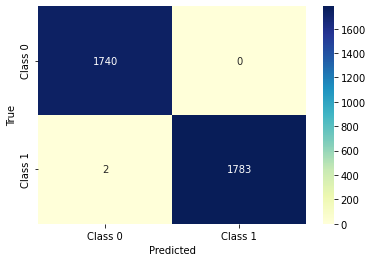

In [15]:
print(": The time and speed analysis of the XGboost algorithm : ")
print(f'The training time of XGboost is: {boost_time_train} sec')
print(f'The prediction speed of the XGboost is: {round(boost_time_pred)} obs/sec')
print("=========================================================")
print(": The classifcation report of the XGboost algorithm : ")
print(classification_report(y_test_std, predictions_test))
print(f"Train Accuracy={train_percentage*100} %")
print(f"Validation set accuracy = {val_percentage*100} %")
print(f"Test Accuracy={test_percentage*100} %")
print("=========================================================")
print(": The confusion matrix of the XGboost algorithm : ")
conf_mat = confusion_matrix(y_test_std, predictions_test)
target_name = ['Class 0', 'Class 1']
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", fmt = 'd', xticklabels=target_name, yticklabels=target_name)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [16]:
model2 = xgb.XGBClassifier(reg_alpha = 50)
start = time.time()
model2.fit(X_train_std, y_train_std)
end = time.time()

In [17]:
predictions_train = model2.predict(X_train_std)
train_percentage = model2.score(X_train_std,y_train_std)

predictions_val = model2.predict(X_val_std)
val_percentage = model2.score(X_val_std, y_val_std)

start1 = time.time()
predictions_test = model2.predict(X_test_std)
end1 = time.time()
boost_time_pred = X_test_std.shape[0] / (end1 -  start1)

test_percentage = model2.score(X_test_std, y_test_std)

boost_time_train = end - start 

: The time and speed analysis of the XGboost algorithm : 
The training time of XGboost is: 0.4844834804534912 sec
The prediction speed of the XGboost is: 386463 obs/sec
: The classifcation report of the XGboost algorithm : 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1740
           1       0.98      1.00      0.99      1785

    accuracy                           0.99      3525
   macro avg       0.99      0.99      0.99      3525
weighted avg       0.99      0.99      0.99      3525

Train Accuracy=99.10472376016021 %
Validation set accuracy = 98.86553219886554 %
Test Accuracy=98.97872340425532 %
: The confusion matrix of the XGboost algorithm : 


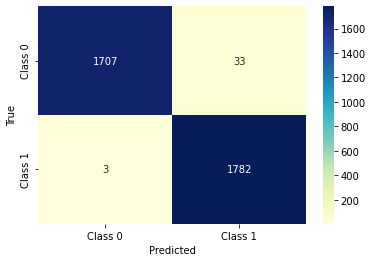

In [18]:
print(": The time and speed analysis of the XGboost algorithm : ")
print(f'The training time of XGboost is: {boost_time_train} sec')
print(f'The prediction speed of the XGboost is: {round(boost_time_pred)} obs/sec')
print("=========================================================")
print(": The classifcation report of the XGboost algorithm : ")
print(classification_report(y_test_std, predictions_test))
print(f"Train Accuracy={train_percentage*100} %")
print(f"Validation set accuracy = {val_percentage*100} %")
print(f"Test Accuracy={test_percentage*100} %")
print("=========================================================")
print(": The confusion matrix of the XGboost algorithm : ")
conf_mat = confusion_matrix(y_test_std, predictions_test)
target_name = ['Class 0', 'Class 1']
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", fmt = 'd', xticklabels=target_name, yticklabels=target_name)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()